In [1]:
import pycocotools
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

import torch
from torch import nn
import torch.utils.data
import torchvision.models as models
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

import requests
import os
import pandas as pd

In [2]:
from python.engine import train_one_epoch, evaluate
from python import utils
import python.transforms as T

In [3]:
def parse_one_annot(path):
    data = {}
    for i,e in enumerate(os.listdir(path)):
        data_bach = pd.read_csv(os.path.join(path,e))
        data_bach = data_bach.values[0]
        x1 = int((data_bach[0].split(" ")[0]).split(".")[0])
        y1 = int((data_bach[0].split(" ")[1]).split(".")[0])
        x2 = int((data_bach[0].split(" ")[2]).split(".")[0])
        y2 = int((data_bach[0].split(" ")[3]).split(".")[0])
        data[e] = [x1,y1,x2,y2]
    return data

In [4]:
a = parse_one_annot("Label")
a['0.csv']

[165, 105, 298, 238]

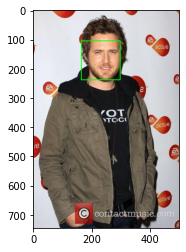

In [5]:
img = cv2.imread(os.path.join("Image","0.jpg"))
x1,y1,x2,y2 = a['0.csv']
cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0), 2)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Test in 1 image

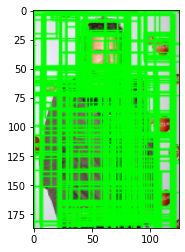

In [7]:
img = cv2.imread(os.path.join("Image","0.jpg"),cv2.COLOR_RGB2HSV)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = img.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

##If le carré vert est dans la tête de monsieur

In [8]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
def getboxes(image):
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    return ss.process()

##Fonction qui retour les point d'une face

In [10]:
train_images=[]
train_labels=[]
counter = 0
for filename in list(a.keys()):#[:1000]:
    try:
        istake = True
        #print(filename)
        image = cv2.imread(os.path.join("Image",filename[:-4]+".jpg"),cv2.COLOR_RGB2HSV)
        x,y,w,h = a[filename]
        x = int(x/244*64)
        y = int(y/244*64)
        w = int(w/244*64)
        h = int(h/244*64)
        bb1 = {"x1":x,"x2":x+w,"y1":y,"y2":y+h}
        boxes = getboxes(image)
        for boxe in boxes[:3000]:
            x,y,w,h = boxe
            iou = get_iou(bb1,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
            if iou > 0.70:
                timage = image[y:y+h,x:x+w]
                resized = cv2.resize(timage, (128,128), interpolation = cv2.INTER_AREA).transpose(2,1,0)
                train_images.append(resized)
                train_labels.append(1)
                break
            if iou < 0.1 and istake == True:
                istake = False
                timage = image[y:y+h,x:x+w]
                resized = cv2.resize(timage, (128,128), interpolation = cv2.INTER_AREA).transpose(2,1,0)
                train_images.append(resized)
                train_labels.append(0)
    except Exception as e:
        #print(e)
        print("error in "+filename)
        continue

OpenCV(4.4.0) c:\users\appveyor\appdata\local\temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xe1e91fed::Set<3,-1,-1>,struct cv::impl::A0xe1e91fed::Set<0,5,-1>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

error in 10063.csv
OpenCV(4.4.0) c:\users\appveyor\appdata\local\temp\1\pip-req-build-wwma2wne\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xe1e91fed::Set<3,-1,-1>,struct cv::impl::A0xe1e91fed::Set<0,5,-1>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)

In [11]:
train_images= torch.tensor(train_images, dtype=torch.float32)
train_labels= torch.tensor(train_labels, dtype=torch.float32)

In [12]:
m, std = train_images.to(torch.float32).mean(), train_images.to(torch.float32).std()
train_images = (train_images - m) / std
train_labels = train_labels.float()

In [13]:
print(train_images.shape)
print(train_labels.shape)

torch.Size([1132, 3, 128, 128])
torch.Size([1132])


In [14]:
print(train_labels)

tensor([0., 0., 1.,  ..., 0., 0., 0.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


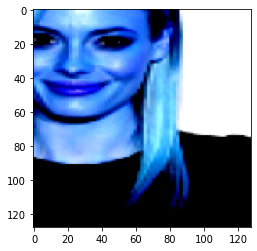

In [15]:
plt.imshow(train_images[17].transpose(2,0))

In [16]:
train, valid = train_images[:70, :], train_images[:20, :]
y_train, y_valid = train_labels[:70], train_labels[20:]

In [17]:
print(train.shape)
print(valid.shape)

torch.Size([70, 3, 128, 128])
torch.Size([20, 3, 128, 128])


In [18]:
class Dataset():
    # A convenience class to have all your data stored at the same place
    # common practice
    def __init__(self, x, y): self.x, self.y = x.cuda(), y.cuda()
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i] 

In [19]:
class Optimizer():
    # is used to get rid of code inside the training loop
    def __init__(self, parameters, lr=0.004):
        self.parameters, self.lr = list(parameters), lr

    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.parameters:
            p.grad.zero_()

In [20]:
from torch.utils.data import DataLoader

In [21]:
train_dl = DataLoader(Dataset(train, y_train), batch_size=64, shuffle=True)
valid_dl = DataLoader(Dataset(valid, y_valid), 64)

In [22]:
EPOCHS = 1
lr = 0.0003 # learning rate
bs = 1
loss_func = torch.nn.BCELoss()

# here we will later download and assign pre-trained models
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096,1)
for layers in (model.classifier)[:15]:
    print(layers)
    layers.trainable = False

# Your nn.Sequential has a .parameters() attribute !
# so the Optimizer find alone all the tensors that require gradients ! 
opt = Optimizer(model.parameters(), lr=lr)

Linear(in_features=25088, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=1, bias=True)


In [23]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to("cpu")# construct an optimizer
#print(torch.cuda.is_available())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
# A cool thing is that the train loop doesn't need to change
for epoch in range(EPOCHS):
    # put your learner in train mode 
    
    for xb, yb in train_dl:
        #xb, yb = data[0].to(device), data[1].to(device)
        # again, practice 
        xb, yb = xb.to("cpu"), yb.to("cpu")
        m = nn.Sigmoid()
        output = model(xb)
        loss = loss_func(m(output),yb)
        # backward pass:
        loss.backward()
        
        # we've removed all the mess into opt: 
        opt.step() #replaces a.weight -= a.weight.grad * lr
        opt.zero_grad()
    # put your learner in eval mode 
    
    with torch.no_grad():
        total_loss = 0.
        for xb, yb in valid_dl:
            #xb, yb = data[0].to(device), data[1].to(device)
            xb, yb = xb.to("cpu"), yb.to("cpu")
            m = nn.Sigmoid()
            pred = model(xb)
            total_loss += loss_func(m(pred), yb)
        n_entries = len(valid_dl)
    print('epoch', epoch,'loss:', (total_loss/n_entries).item())

d:\python\python38\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
d:\python\python38\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
d:\python\python38\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch 0 loss: 0.6793838739395142
epoch 1 loss: 0.5826307535171509
epoch 2 loss: 0.6674733757972717
epoch 3 loss: 0.5669386386871338
epoch 4 loss: 0.5418069958686829
epoch 5 loss: 0.5029268264770508
epoch 6 loss: 0.46589192748069763
epoch 7 loss: 0.46056079864501953
epoch 8 loss: 0.45124906301498413
epoch 9 loss: 0.4437028765678406


In [25]:
PATH = 'RCNN.pth'
torch.save(model.state_dict(), PATH)

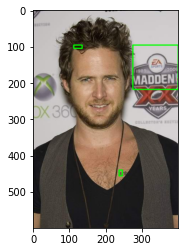

In [28]:
path = "Image"
file = "2.jpg"

img = cv2.imread(os.path.join(path,file))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()

learner = models.vgg16()
learner.classifier[6] = nn.Linear(4096,1)
learner.load_state_dict(torch.load(PATH))

for e,result in enumerate(ssresults):
        if e < 100:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (128,128), interpolation = cv2.INTER_AREA).transpose(2,1,0)
            img = np.expand_dims(resized, axis=0)
            out= learner(torch.tensor(img).float())
            m = nn.Sigmoid()
            #print(m(out[0][0]))
            if m(out[0][0]) > 0.65:
                #print("visage !")
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)  
                #break
plt.figure()
plt.imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))